In [1]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
import numpy as np
import ast

In [2]:
# Define a function to convert a string representation of a list to a float
def parse_string_to_float(s):
    try:
        # Attempt to evaluate the string as a literal expression (list),
        # and then convert the first element to a float
        return float(ast.literal_eval(s)[0])
    except (ValueError, SyntaxError):
        # If there is an error, return NaN
        return np.nan

# Define a function to calculate the metrics
def calculate_metrics(file_path):
    # Read the CSV file
    df = pd.read_csv(file_path)

    # Apply the conversion function to each row in the 'target' and 'output' columns
    df['target'] = df['target'].apply(parse_string_to_float)
    df['output'] = df['output'].apply(parse_string_to_float)

    # Drop any rows that contain NaN values
    df = df.dropna()

    # Calculate RMSE (Root Mean Squared Error)
    rmse = np.sqrt(mean_squared_error(df["target"], df["output"]))
    # Calculate MAE (Mean Absolute Error)
    mae = mean_absolute_error(df["target"], df["output"])
    # Calculate R2 Score (Coefficient of Determination)
    r2 = r2_score(df["target"], df["output"])
    # Calculate PCC (Pearson Correlation Coefficient)
    pcc, _ = pearsonr(df["target"], df["output"])

    # Return the calculated metrics
    return rmse, mae, r2, pcc

In [3]:
import glob
import csv

# Assuming calculate_metrics function is already defined as shown above

# Define the path for the output CSV file
output_csv_path = 'SATCMF_train_result.csv'  # Change this to your desired output path

# Open the output CSV file for writing
with open(output_csv_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the header row
    writer.writerow(['file_label', 'train_rmse', 'train_mae', 'train_r2', 'train_pcc', 'test_rmse', 'test_mae', 'test_r2', 'test_pcc'])

    # Iterate over the folders and files, calculate metrics, and write to the CSV
    for fold in glob.glob("/mnt/USR_DATA/ChenGeng/Project/SATCMF-main/data_analysize/SATCMF_train_reslut/*"):
        fold_label = fold.split("/")[-1]
        fold_files = glob.glob(f"{fold}/Metal/edge_attr/*")
        for file in fold_files:
            file_label = fold_label +  "_" + file.split("/")[-1].split("_0.2_")[0]
            
            # Construct the file paths for train and test CSV files
            train_csv_path = f"{file}/train_output.csv"
            test_csv_path = f"{file}/test_output.csv"
            
            # Calculate metrics for train dataset
            train_rmse, train_mae, train_r2, train_pcc = calculate_metrics(train_csv_path)
            print(train_rmse, train_mae, train_r2, train_pcc)
            # Calculate metrics for test dataset
            test_rmse, test_mae, test_r2, test_pcc = calculate_metrics(test_csv_path)
            print(test_rmse, test_mae, test_r2, test_pcc)
            
            # Write the metrics to the CSV file
            writer.writerow([file_label, train_rmse, train_mae, train_r2, train_pcc, test_rmse, test_mae, test_r2, test_pcc])

print(f"Metrics have been written to {output_csv_path}")

0.7044735218462929 0.2842776095809954 0.9864950641512494 0.9932619047154799
1.9360843614162155 0.7951151546631151 0.9097785052572066 0.9542569978867039
0.7242446726045354 0.3180994479688267 0.9857263910217682 0.9928671014089748
2.113200179182654 0.8065766742211262 0.8925162669380009 0.9451278201221178
0.808664667441905 0.3392089197228267 0.9822049131133673 0.9910813421601153
1.7819948924174858 0.7900622004771051 0.9235681496086541 0.9616621435038983
0.7102229919633171 0.2632679005895604 0.9862737270178557 0.9931303050755871
1.977364582473994 0.7763886856668778 0.9058901749488224 0.9519789578338994
0.683825267763576 0.31851234044977383 0.9872751267532017 0.9936271953802954
1.9763860683429544 0.8135315675771874 0.9059832938499299 0.9519599976585141
0.8300677234844378 0.3367776274174793 0.9812504766929876 0.9905890021482872
1.8711551659629222 0.8459991148409952 0.9157284329266091 0.9575500988395825
0.8526149687854351 0.3558571267585258 0.9802180507857334 0.9900610132797696
1.7140215242888

In [5]:
import pandas as pd

# Assume your data is stored in a CSV file
file_path = "SATCMF_train_result.csv"

# Read the data
df = pd.read_csv(file_path)

# Extract labels, remove 'foldX_' prefix, and keep everything before the last underscore
df['label'] = df['file_label'].str.replace(r'^fold[1-9]_|^fold10_', '', regex=True)

# Ensure only numeric columns are selected for aggregation
numeric_cols = df.select_dtypes(include=[float, int]).columns
agg_dict = {col: ['mean', 'std'] for col in numeric_cols}

# Group the data and aggregate only numeric columns
grouped = df.groupby('label')
result = grouped.agg(agg_dict)

# Format as 'mean ± std' and keep three decimal places
for col in numeric_cols:
    result[(col, 'formatted')] = result[(col, 'mean')].map('{:.3f}'.format) + " ± " + result[(col, 'std')].map('{:.3f}'.format)

# Select the formatted columns
formatted_columns = [(col, 'formatted') for col in numeric_cols]
result_formatted = result[formatted_columns]

# Rename the columns, remove multi-level index
result_formatted.columns = [col[0] for col in result_formatted.columns.values]

# Reset the index, making label as a column
result_formatted.reset_index(inplace=True)

# Output to a CSV file
result_formatted.to_csv('SATCMF_train_result_formatted.csv', index=False)

print("Formatted CSV file has been generated.")

Formatted CSV file has been generated.


/tmp/ipykernel_1070506/916416160.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:.1f}'.format(x) for x in ax.get_yticks()])


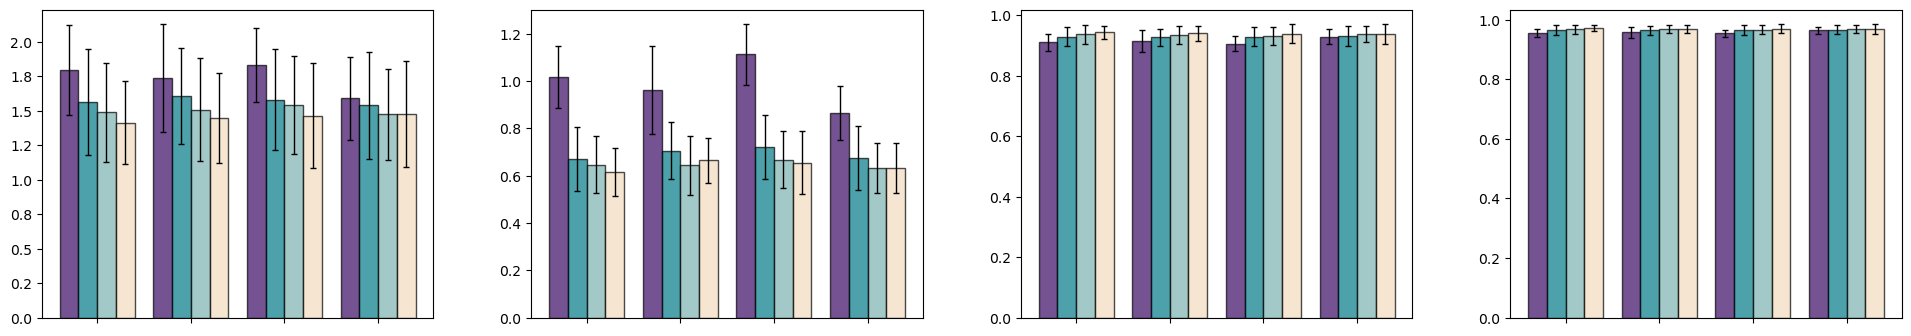

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

file_path = 'SATCMF_train_result_formatted_add_basegnn.csv'
df = pd.read_csv(file_path)

for col in df.columns[1:]:
    df[[f'{col}_mean', f'{col}_std']] = df[col].str.extract(r'([0-9.]+) ± ([0-9.]+)').astype(float)

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(24, 4))

metrics = df.columns[1:].str.replace(r'(_mean|_std)$', '').unique()
metrics = [metric for metric in metrics if 'test' in metric.lower()]
bar_width = 0.20
error_kw = {'capsize': 2, 'capthick': 1, 'elinewidth': 1}

color_nosat = (125/255, 103/255, 75/255)
color_1 = (1/255, 121/255, 135/255)
color_2 = (123/255, 178/255, 176/255)
color_3 = (242/255, 218/255, 190/255)
color_default = (58/255, 9/255, 100/255)

for ax, metric in zip(axes, metrics):
    means = df[f'{metric}_mean']
    stds = df[f'{metric}_std']
    labels = df['label']
    
    if len(labels) % 4 != 0:
        raise ValueError("标签的数量必须能被4整除以便成对分组。")
    
    n_groups = len(labels) // 4
    x_pos = np.arange(n_groups) * (bar_width * 5)
    
    colors = [
        color_nosat if 'nosat' in label else
        color_1 if label.split("_")[-1] == '1' else
        color_2 if label.split("_")[-1] == '2' else
        color_3 if label.split("_")[-1] == '3' else
        color_default
        for label in labels
    ]

    [ax.bar(x_pos + i * bar_width, means[i::4], yerr=stds[i::4], width=bar_width,
            align='center', alpha=0.7, color=colors[i::4], edgecolor='black', error_kw=error_kw)
     for i in range(4)]
    
    ax.set_xticks(x_pos + bar_width * 1.5)
    ax.set_xticklabels([])
    ax.set_ylabel('')
    ax.set_yticklabels(['{:.1f}'.format(x) for x in ax.get_yticks()])

plt.subplots_adjust(wspace=0.25)

plt.savefig('SATCMF_train_result_formatted_add_basegnn.png', dpi=1000 , bbox_inches='tight')

plt.show()